In [1]:
import pandas as pd

data=pd.read_csv("18100205.csv")

data.head() #to display the first 5 lines of loaded data

,REF_DATE,GEO,DGUID,New housing price indexes,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1981-01,Canada,2016A000011124,Total (house and land),"Index, 201612=100",347,units,0,v111955442,1.1,38.2,NaN,NaN,NaN,1
1,1981-01,Canada,2016A000011124,House only,"Index, 201612=100",347,units,0,v111955443,1.2,36.1,NaN,NaN,NaN,1
2,1981-01,Canada,2016A000011124,Land only,"Index, 201612=100",347,units,0,v111955444,1.3,40.6,NaN,NaN,NaN,1
3,1981-01,Atlantic Region,2016A00011,Total (house and land),"Index, 201612=100",347,units,0,v111955445,2.1,NaN,..,NaN,NaN,1
4,1981-01,Atlantic Region,2016A00011,House only,"Index, 201612=100",347,units,0,v111955446,2.2,NaN,..,NaN,NaN,1


In [2]:
data.dtypes

REF_DATE                      object
GEO                           object
DGUID                         object
New housing price indexes     object
UOM                           object
UOM_ID                         int64
SCALAR_FACTOR                 object
SCALAR_ID                      int64
VECTOR                        object
COORDINATE                   float64
VALUE                        float64
STATUS                        object
SYMBOL                       float64
TERMINATED                   float64
DECIMALS                       int64
dtype: object

In [2]:
data = data[['REF_DATE', 'GEO', 'New housing price indexes', 'VALUE']].rename(columns = {'New housing price indexes' : 'HPI_TYPE', 'VALUE' : 'HPI'})

In [4]:
data.head()

,REF_DATE,GEO,HPI_TYPE,HPI
0,1981-01,Canada,Total (house and land),38.2
1,1981-01,Canada,House only,36.1
2,1981-01,Canada,Land only,40.6
3,1981-01,Atlantic Region,Total (house and land),NaN
4,1981-01,Atlantic Region,House only,NaN


In [3]:
filtered_data1 = data.loc[data.GEO == 'Canada']

In [4]:
filtered_data = filtered_data1.loc[filtered_data1.HPI_TYPE == 'Total (house and land)']

In [5]:
filtered_data.head()

,REF_DATE,GEO,HPI_TYPE,HPI
0,1981-01,Canada,Total (house and land),38.2
120,1981-02,Canada,Total (house and land),38.7
240,1981-03,Canada,Total (house and land),39.3
360,1981-04,Canada,Total (house and land),39.9
480,1981-05,Canada,Total (house and land),40.6


In [6]:
filtered_data2 = filtered_data[['REF_DATE', 'HPI']]

filtered_data2.REF_DATE = pd.to_datetime(filtered_data2.REF_DATE)
filtered_data2.set_index('REF_DATE', inplace=True)

#filtered_data.index = pd.to_datetime(filtered_data.index, format='%Y-%m', errors='coerce').dropna()

filtered_data2.dtypes

#filtered_data2.tail()

C:\Users\prasa\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


HPI    float64
dtype: object

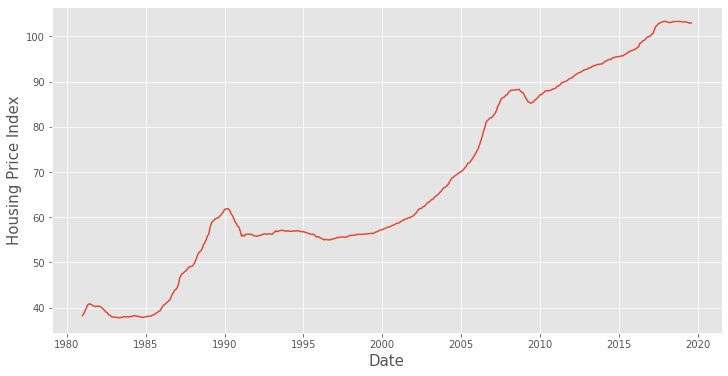

In [7]:
from datetime import date, timedelta
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
%matplotlib inline
style.use('ggplot')
register_matplotlib_converters()

plt.figure(figsize = (12,6))
plt.plot(filtered_data2["HPI"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Housing Price Index',fontsize=15)
plt.show()

In [8]:
# change the dates into ints for training 
filtered_data3 = filtered_data2.copy()
filtered_data3 = filtered_data3.reset_index()

# Store the original dates for plotting the predicitons
org_dates = filtered_data3['REF_DATE']

# convert to ints
filtered_data3['REF_DATE_INT'] = (filtered_data3['REF_DATE'].map(mdates.date2num))#%700000)/2318

filtered_data3.insert(0, 'New_ID', range(100, 100 + len(filtered_data3)))

filtered_data3.head()
#filtered_data3['REF_DATE_INT'].astype(int) *2381+700000

,New_ID,REF_DATE,HPI,REF_DATE_INT
0,100,1981-01-01,38.2,723181.0
1,101,1981-02-01,38.7,723212.0
2,102,1981-03-01,39.3,723240.0
3,103,1981-04-01,39.9,723271.0
4,104,1981-05-01,40.6,723301.0


In [9]:
from sklearn.svm import SVR
from sklearn import preprocessing
import numpy as np 

train =  filtered_data3.iloc[:-30]
test = filtered_data3.tail(30)
train_dates = train[['REF_DATE_INT']].values
train_id = train[['New_ID']].values
test_dates = test[['REF_DATE_INT']].values
test_id = test[['New_ID']].values
train_hpi = train[['HPI']].values
test_hpi = test[['HPI']].values

#Convert to 1d Vector
train_dates = np.reshape(train_dates, (len(train_dates), 1))
train_id = np.reshape(train_id, (len(train_id), 1))
train_hpi = np.reshape(train_hpi, (len(train_hpi), 1))
test_dates = np.reshape(test_dates, (len(test_dates), 1))
test_id = np.reshape(test_id, (len(test_id), 1))
test_hpi = np.reshape(test_hpi, (len(test_hpi), 1))

In [10]:
from sklearn.model_selection import GridSearchCV 

import warnings
warnings.filterwarnings('ignore')

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
            'kernel': ['rbf']} 

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
grid.fit(train_id, train_hpi) 

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-6.969, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-0.516, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ........ C=0.1, gamma=1, kernel=rbf, score=-21.389, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-6.968, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-0.640, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ...... C=0.1, gamma=0.1, kernel=rbf, score=-21.396, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ...... C=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ C=10, gamma=0.1, kernel=rbf, score=-4.381, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ....... C=10, gamma=0.1, kernel=rbf, score=-25.301, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ....... C=10, gamma=0.01, kernel=rbf, score=-9.141, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ....... C=10, gamma=0.01, kernel=rbf, score=-3.867, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ...... C=10, gamma=0.01, kernel=rbf, score=-24.892, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ...... C=10, gamma=0.001, kernel=rbf, score=-8.937, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ...... C=10, gamma=0.001, kernel=rbf, score=-3.559, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [11]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


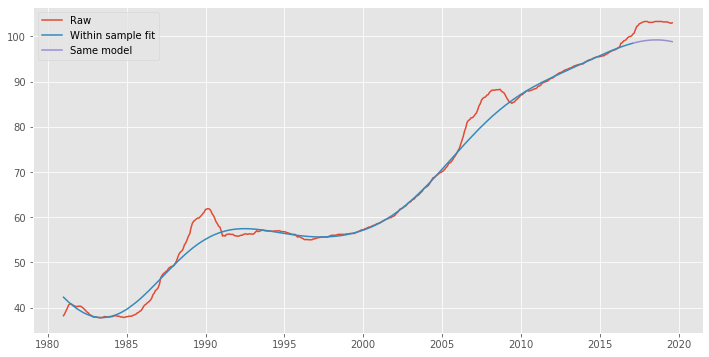

In [12]:
svr_rbf_original = SVR(kernel='rbf', C= 10, gamma= .0001, epsilon=0.1) 
#svr_rbf_original.fit(train_dates, train_hpi)
svr_rbf_original.fit(train_id, train_hpi)

#svr_rbf_twicked = SVR(kernel='rbf', C= 100, epsilon=0.005, gamma=.00001)
#svr_rbf_twicked.fit(train_dates, train_hpi)
#svr_rbf_twicked.fit(train_id, train_hpi)

plt.figure(figsize = (12,6))
plt.plot(filtered_data3['REF_DATE'], filtered_data3['HPI'], label='Raw Data')  
plt.plot(train_dates, svr_rbf_original.predict(train_id), label='RBF Model')
plt.plot(test_dates, svr_rbf_original.predict(test_id), label='Forecast')
#plt.plot(test_dates, svr_rbf_twicked.predict(test_id), label='Fit eps:0.005 / gamma:0.001') 
plt.legend() 
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_hpi, svr_rbf_original.predict(test_id))
print(error)

15.688047458914703


In [14]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
            'kernel': ['linear']} 

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
grid.fit(train_id, train_hpi) 

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-2.162, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-4.374, total=   0.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ...... C=0.1, gamma=1, kernel=linear, score=-4.801, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .... C=0.1, gamma=0.1, kernel=linear, score=-2.162, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .... C=0.1, gamma=0.1, kernel=linear, score=-4.374, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .... C=0.1, gamma=0.1, kernel=linear, score=-4.801, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] ... C=0.1, gamma=0.01, kernel=linear, score=-2.162, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] ... C=0.1, gamma=0.01, kernel=linear, score=-4.374, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] ... C=0.1, gamma=0.01, kernel=linear, score=-4.801, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] .. C=0.1, gamma=0.001, kernel=linear, score=-2.162, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] .. C=0.1, gamma=0.001, kernel=linear, score=-4.374, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] .

[CV] ..... C=1000, gamma=1, kernel=linear, score=-4.801, total= 3.0min
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] ... C=1000, gamma=0.1, kernel=linear, score=-2.162, total= 3.1min
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] ... C=1000, gamma=0.1, kernel=linear, score=-4.374, total= 8.6min
[CV] C=1000, gamma=0.1, kernel=linear ................................
[CV] ... C=1000, gamma=0.1, kernel=linear, score=-4.801, total= 2.9min
[CV] C=1000, gamma=0.01, kernel=linear ...............................
[CV] .. C=1000, gamma=0.01, kernel=linear, score=-2.162, total= 3.1min
[CV] C=1000, gamma=0.01, kernel=linear ...............................
[CV] .. C=1000, gamma=0.01, kernel=linear, score=-4.374, total= 8.6min
[CV] C=1000, gamma=0.01, kernel=linear ...............................
[CV] .. C=1000, gamma=0.01, kernel=linear, score=-4.801, total= 2.9min
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 80.9min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [15]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


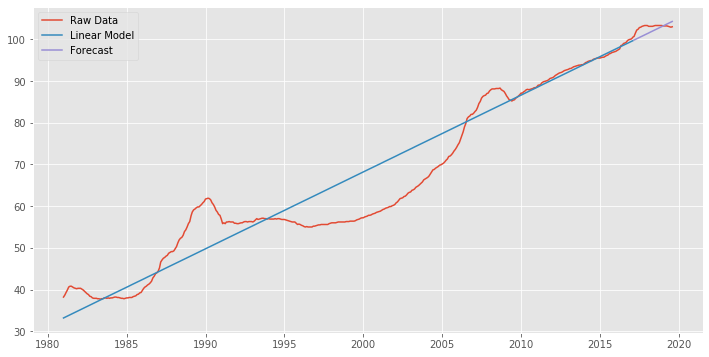

In [16]:
 svr_linear_original = SVR(kernel='linear', C= 0.1, gamma= 1, epsilon=0.1) 
#svr_rbf_original.fit(train_dates, train_hpi)
svr_linear_original.fit(train_id, train_hpi)


plt.figure(figsize = (12,6))
plt.plot(filtered_data3['REF_DATE'], filtered_data3['HPI'], label='Raw Data')  
plt.plot(train_dates, svr_linear_original.predict(train_id), label='Linear Model')
plt.plot(test_dates, svr_linear_original.predict(test_id), label='Forecast')
#plt.plot(test_dates, svr_rbf_twicked.predict(test_id), label='Fit eps:0.005 / gamma:0.001') 
plt.legend() 
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_hpi, svr_linear_original.predict(test_id))
print(error)

2.118095657489247


In [ ]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
            'kernel': ['poly']} 

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 5) 

# fitting the model for grid search 
grid.fit(train_id, train_hpi) 

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=poly .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
            'kernel': ['sigmoid']} 

grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 5) 

# fitting the model for grid search 
grid.fit(train_id, train_hpi)

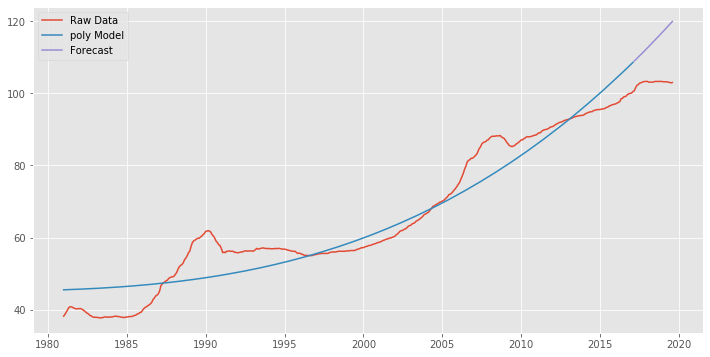

In [18]:
svr_poly_original = SVR(kernel='poly', C= 10, gamma= .0001, epsilon=0.1) 
#svr_rbf_original.fit(train_dates, train_hpi)
svr_poly_original.fit(train_id, train_hpi)

#svr_rbf_twicked = SVR(kernel='rbf', C= 100, epsilon=0.005, gamma=.00001)
#svr_rbf_twicked.fit(train_dates, train_hpi)
#svr_rbf_twicked.fit(train_id, train_hpi)

plt.figure(figsize = (12,6))
plt.plot(filtered_data3['REF_DATE'], filtered_data3['HPI'], label='Raw Data')  
plt.plot(train_dates, svr_poly_original.predict(train_id), label='poly Model')
plt.plot(test_dates, svr_poly_original.predict(test_id), label='Forecast')
#plt.plot(test_dates, svr_rbf_twicked.predict(test_id), label='Fit eps:0.005 / gamma:0.001') 
plt.legend() 
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_hpi, svr_poly_original.predict(test_id))
print(error)

138.62226352340028
